In [2]:
import sys
sys.path.append("..")
import random

In [1]:
import dataset.ade as ade
from dataset.ade import AdeSegmentationIncremental
import dataset.transform as transforms
import torchvision as tv
import numpy as np
import os

ModuleNotFoundError: No module named 'dataset'

In [4]:
data = ade.AdeSegmentation('/vandal/datasets', train=True)


In [5]:
def group_images(dataset, labels):
    # Group images based on the label in LABELS
    idxs = [[] for lab in labels]

    labels_cum = labels + [0, 255]
    for i in range(len(dataset)):
        cls = np.unique(np.array(dataset[i][1]))
        if all(x in labels_cum for x in cls):
            for x in cls:
                if x in labels:
                    idxs[x].append(i)
        else:
            print(f"Not all in labels_cum: {cls}")
        if i % 1000 == 0:
            print(f"Done {i} / {len(dataset)}")
    return idxs

idxs = group_images(data, list(range(151)))


Done 0 / 20210
Done 1000 / 20210
Done 2000 / 20210
Done 3000 / 20210
Done 4000 / 20210
Done 5000 / 20210
Done 6000 / 20210
Done 7000 / 20210
Done 8000 / 20210
Done 9000 / 20210
Done 10000 / 20210
Done 11000 / 20210
Done 12000 / 20210
Done 13000 / 20210
Done 14000 / 20210
Done 15000 / 20210
Done 16000 / 20210
Done 17000 / 20210
Done 18000 / 20210
Done 19000 / 20210
Done 20000 / 20210


In [6]:
len_idxs = [len(idxs[i]) for i in range(151)]
print(len_idxs)

[20208, 11588, 6042, 8240, 9314, 6674, 6579, 3990, 1825, 4687, 2421, 2851, 3061, 5069, 1791, 3276, 4266, 1690, 3995, 2148, 3258, 3161, 702, 3295, 1191, 1404, 667, 650, 1229, 1132, 479, 1172, 521, 1385, 698, 781, 378, 3083, 404, 803, 1447, 411, 1437, 799, 2646, 549, 367, 310, 1181, 287, 468, 402, 130, 561, 880, 84, 172, 198, 930, 139, 564, 320, 261, 275, 335, 792, 395, 1308, 1112, 266, 658, 330, 531, 369, 144, 265, 324, 304, 170, 68, 65, 247, 492, 2508, 440, 135, 583, 532, 1987, 71, 618, 133, 83, 178, 992, 181, 451, 41, 307, 965, 117, 354, 108, 556, 52, 99, 57, 66, 77, 340, 66, 465, 50, 622, 80, 59, 530, 282, 73, 213, 136, 116, 266, 58, 417, 319, 1191, 97, 347, 52, 246, 108, 201, 284, 268, 1020, 1281, 528, 452, 671, 397, 92, 228, 556, 217, 206, 126, 178, 504, 773, 421]


In [7]:
# step 1 - init
# parameters
exemplar = 100
cl = list(range(101, 151))
full_len_incr = int(len(data) * len(cl)/150)
random.seed(42)
group_idxs = idxs  # call previous function group_images to compute this.

new = set()
all_new = set()
all_old = set()
for cl in range(1, 101):
    all_old.update(idxs[cl])

len(new), full_len_incr

(0, 6736)

In [8]:
# step 2 - sample e images from each class
for cl in range(101, 151):
    all_new.update(idxs[cl])
    # here we must put the exemplar selection: for each class (taken from filter images)
    class_idx = set(group_idxs[cl]).difference(new)
    idx_cl = random.sample(class_idx, min(exemplar, len(class_idx)))  # we use random here!
    new.update(idx_cl)

len(new)

4523

In [9]:
# step 3 - add all images excluded from new without labels in the first set
new.update(all_new.difference(all_old))

len(new)

4523

In [10]:
# step 4 - add remining images to get the desired lenght
while len(new) < full_len_incr:
    additionals_idxs = random.sample(all_new, full_len_incr - len(new))
    new.update(additionals_idxs)
len(new) 

6736

In [11]:
first = all_old.difference(new)
len(first)

13460

In [12]:
len(first) + len(new) # -> should be 20210

20196

In [104]:
os.makedirs("../data/ade/100-50-w", exist_ok=True)
np.save("../data/ade/100-50-w/train-0.npy", np.array(list(first)))
np.save("../data/ade/100-50-w/train-1.npy", np.array(list(new)))

In [13]:
class_members = {}
for i,l in enumerate(idxs):
    class_members[i]=len(l)
    
true_length = [11664, 6046, 8265, 9336, 6678, 6604, 4023, 1906, 4688, 2423, 2874, 3068, 5075, 1804, 6666, 4269, 1691, 3999, 2149, 3261, 3164, 709, 3296, 1191, 1516, 667, 651, 1847, 1158, 480, 1172, 1292, 1386, 698, 781, 380, 3089, 404, 804, 1453, 411, 1440, 800, 2650, 549, 367, 311, 1181, 287, 468, 402, 130, 561, 880, 86, 172, 198, 930, 139, 564, 320, 261, 275, 335, 792, 395, 1309, 1112, 266, 659, 331, 531, 369, 144, 265, 324, 304, 170, 68, 65, 248, 492, 2510, 440, 147, 583, 533, 1989, 71, 618, 135, 83, 178, 1003, 182, 452, 42, 307, 965, 117, 354, 108, 557, 52, 99, 57, 292, 77, 340, 66, 465, 50, 622, 80, 59, 531, 282, 73, 435, 136, 116, 266, 58, 418, 319, 1193, 97, 347, 52, 246, 108, 201, 285, 268, 1020, 1282, 528, 453, 671, 397, 92, 228, 570, 217, 206, 130, 178, 504, 775,421]

'''for i in range(0,len(true_length)):
    if true_length[i]!=class_members[i+1]:
        print(i,true_length[i],class_members[i+1])'''

#random.seed(42)
ordered_classes = (sorted(class_members.items(), key = lambda x : x[1]))
imgs_A = set()
imgs_B= set()
added = {}
all_added = set()
x=100
A = [i for i in range(1,101)]#list(random.sample(set([i for i in range(1,151)]),100))
B = [i for i in range(101,151)]


# ship,fountain,convey belt, canopy, washer, pool, barrel, waterfall, tent, cradle, tank, animal, lake, dock

# runway, hovel, booth, escalator, airplane, dirt track
exclude = [92,80,89,97,55,91]

# trade name, toy, step, clock, oven, pot
include = [124,109,122,149,119, 126]


for i,c in ordered_classes:

    if (i in A and not i in exclude) or i in include:
        class_idx = set(idxs[i]).difference(imgs_A)
        ns = random.sample(class_idx, min(x, len(class_idx)))
        all_added.update(ns) 
        imgs_B.update(ns)
        added[i] = len(ns)#len(imgs_B)-old
    else:
        class_idx = set(idxs[i]).difference(imgs_B)
        ns = random.sample(class_idx, min(x, len(class_idx)))
        all_added.update(ns) 
        imgs_A.update(ns)
        added[i] = len(ns)#len(imgs_A)-old
    
        
for i in range(len(added)):
    if(added[i]<x) and added[i]<len(idxs[i]):
        print(i,added[i],class_members[i])


In [64]:
    i=72
    set1 = set(idxs[i])
    print(len(idxs[i]))
    for j in range(1,151):
        intersection = set1.intersection(idxs[j])
        it = len(intersection)
        r1 = (it+0.0)/len(set1)
        r2 = (it+0.0)/len(idxs[j])
        if r1>0 and (len(set1)>=len(idxs[j])):
            print(i,j,r1,r2,len(set1),len(idxs[j]))


531
72 32 0.009416195856873822 0.009596928982725527 531 521
72 36 0.013182674199623353 0.018518518518518517 531 378
72 41 0.0018832391713747645 0.0024330900243309003 531 411
72 46 0.04143126177024482 0.05994550408719346 531 367
72 50 0.013182674199623353 0.014957264957264958 531 468
72 51 0.4331450094161959 0.572139303482587 531 402
72 63 0.005649717514124294 0.01090909090909091 531 275
72 64 0.035781544256120526 0.056716417910447764 531 335
72 71 0.01694915254237288 0.02727272727272727 531 330
72 72 1.0 1.0 531 531
72 74 0.17702448210922786 0.6527777777777778 531 144
72 76 0.003766478342749529 0.006172839506172839 531 324
72 78 0.0018832391713747645 0.0058823529411764705 531 170
72 82 0.026365348399246705 0.028455284552845527 531 492
72 96 0.003766478342749529 0.004434589800443459 531 451
72 98 0.003766478342749529 0.006514657980456026 531 307
72 100 0.007532956685499058 0.03418803418803419 531 117
72 101 0.013182674199623353 0.01977401129943503 531 354
72 108 0.01694915254237288 0.11

# TEST ADE INCREMENTAL

In [295]:
data_inc = AdeSegmentationIncremental('/vandal/datasets', labels=[x for x in range(101,151)], labels_old=[x for x in range(101)], masking=True, transform=transforms.ToTensor(), idxs_path="../data/ade/100-50-w/train-1.npy")



Filtering images...
	0/20210 ...


KeyboardInterrupt: 

In [ ]:
idx = random.randint(0, len(data_inc))

to_image = tv.transforms.ToPILImage()

to_image(data_inc[idx][0])


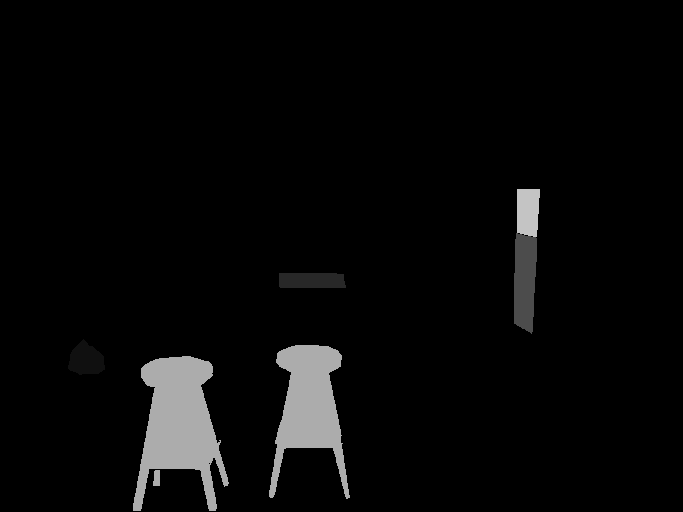

In [128]:
to_image(data_inc[idx][1]*20)

In [129]:
cls = np.unique(np.array(data_inc[idx][1]))
cls

array([  0, 111, 116, 119, 125, 130], dtype=uint8)

In [14]:
class_members = {}
for i,l in enumerate(idxs):
    class_members[i]=len(l)
    
true_length = [11664, 6046, 8265, 9336, 6678, 6604, 4023, 1906, 4688, 2423, 2874, 3068, 5075, 1804, 6666, 4269, 1691, 3999, 2149, 3261, 3164, 709, 3296, 1191, 1516, 667, 651, 1847, 1158, 480, 1172, 1292, 1386, 698, 781, 380, 3089, 404, 804, 1453, 411, 1440, 800, 2650, 549, 367, 311, 1181, 287, 468, 402, 130, 561, 880, 86, 172, 198, 930, 139, 564, 320, 261, 275, 335, 792, 395, 1309, 1112, 266, 659, 331, 531, 369, 144, 265, 324, 304, 170, 68, 65, 248, 492, 2510, 440, 147, 583, 533, 1989, 71, 618, 135, 83, 178, 1003, 182, 452, 42, 307, 965, 117, 354, 108, 557, 52, 99, 57, 292, 77, 340, 66, 465, 50, 622, 80, 59, 531, 282, 73, 435, 136, 116, 266, 58, 418, 319, 1193, 97, 347, 52, 246, 108, 201, 285, 268, 1020, 1282, 528, 453, 671, 397, 92, 228, 570, 217, 206, 130, 178, 504, 775,421]

'''for i in range(0,len(true_length)):
    if true_length[i]!=class_members[i+1]:
        print(i,true_length[i],class_members[i+1])'''

#random.seed(42)
ordered_classes = (sorted(class_members.items(), key = lambda x : x[1]))
imgs_A = set()
imgs_B= set()
added = {}
all_added = set()
B={}
sets = 5
A = [i for i in range(1,101)]
for i in range(1,sets+1):
    B[i] = [i*100+j for j in range(1,50//sets+1)]

random.seed(42)
imgs={}
others = {}
every=set()
added = [0 for i in range(151)]
for i in range(sets+1):
    others[i]=set()
    imgs[i]=set()
x=80
r=1.
turns = 100

change={}#149:0,136:0}#72:4,, 51:4, 125:4, }
for t in range(turns):
    before=every.copy()
    counter=0
    for i,c in ordered_classes:
        counter+=1
        if (added[i]>=len(idxs[i]) or i==0):# or (counter>100 and not t>20):
            continue
        
        
        assignment = i//101 + max((i-101)//(50//sets),0)
        if i in change.keys():
            assignment=change[i]
        class_idx = set(idxs[i]).difference(before.union(others[assignment]))
        ns = random.sample(class_idx, min(int(r*len(class_idx)),x))
        every.update(ns)
        for j in range(len(others)):
            if j!=assignment:
                others[j].update(ns) 
        imgs[assignment].update(ns)
        added[i] += len(ns)
        
for i in range(len(added)):        
        assignment = i//101 + max((i-101)//(50//sets),0)      
        if i in change.keys():
            assignment=change[i]
        ratio = len(set(idxs[i]).intersection(imgs[assignment]))/class_members[i]
        if len(set(idxs[i]).intersection(imgs[assignment]))<class_members[i] and class_members[i]<100:#ratio<0.5:
            print(i,ratio, class_members[i], len(set(idxs[i]).intersection(imgs[assignment])))

55 0.9285714285714286 84 78
80 0.9846153846153847 65 64
89 0.9859154929577465 71 70
92 0.9759036144578314 83 81
105 0.8686868686868687 99 86
108 0.987012987012987 77 76
114 0.975 80 78
115 0.9830508474576272 59 58
118 0.9863013698630136 73 72
123 0.9655172413793104 58 56
127 0.9381443298969072 97 91
141 0.8804347826086957 92 81


In [274]:
for i in range(len(added)):        
        assignment = i//101 + max((i-101)//(50//sets),0)
        if i in change.keys():
            assignment=change[i]
        ratios = [len(set(idxs[i]).intersection(imgs[j]))/class_members[i] for j in range(0,sets+1)]
        if ratios[assignment]<0.5:
            print(i,ratios[assignment], sum(ratios[1:]), class_members[i], len(set(idxs[i]).intersection(imgs[j])))
s=0
for i in range(sets+1):
    print(len(imgs[i]))
    s+=len(imgs[i])
    
print(s)
    

51 0.48009950248756217 0.5199004975124378 402 13
72 0.4030131826741996 0.5969868173258004 531 14
101 0.4774011299435028 0.7259887005649718 354 24
103 0.3489208633093525 0.5773381294964028 556 12
109 0.4588235294117647 0.7264705882352942 340 12
111 0.33548387096774196 0.5548387096774193 465 23
113 0.2572347266881029 0.5755627009646302 622 34
116 0.36981132075471695 0.6415094339622641 530 38
119 0.47417840375586856 0.7230046948356808 213 6
124 0.4988009592326139 0.7386091127098321 417 16
125 0.40752351097178685 0.7084639498432602 319 9
126 0.20067170445004198 0.4861460957178842 1191 88
134 0.3656716417910448 0.7201492537313433 268 5
135 0.23627450980392156 0.44313725490196076 1020 100
136 0.20921155347384857 0.429352068696331 1281 121
137 0.35984848484848486 0.6401515151515152 528 19
138 0.37610619469026546 0.654867256637168 452 26
139 0.2965722801788376 0.6199701937406856 671 43
140 0.4332493702770781 0.5717884130982368 397 14
143 0.3147482014388489 0.6384892086330936 556 175
148 0.3472

In [82]:
r=0.5
for i in range(1,150):
    set1 = set(idxs[i])
    for j in range(1,151):
        if i==j:
            continue
        intersection = set1.intersection(idxs[j])
        it = len(intersection)
        r1 = (it+0.0)/len(set1)
        r2 = (it+0.0)/len(idxs[j])
        if r1>r and r2>r:
            print(i,j,r1,r2,len(set1),len(idxs[j]))

1 4 0.7801173627890922 0.9705819196907881 11588 9314
1 6 0.5581636175353815 0.9831281349749202 11588 6579
2 3 0.837471036080768 0.6140776699029126 6042 8240
2 5 0.6593843098311817 0.5969433623014684 6042 6674
2 7 0.5566037735849056 0.8428571428571429 6042 3990
3 2 0.6140776699029126 0.837471036080768 8240 6042
3 5 0.6770631067961165 0.8359304764758765 8240 6674
4 1 0.9705819196907881 0.7801173627890922 9314 11588
4 6 0.6471977668026626 0.9162486700106399 9314 6579
5 2 0.5969433623014684 0.6593843098311817 6674 6042
5 3 0.8359304764758765 0.6770631067961165 6674 8240
6 1 0.9831281349749202 0.5581636175353815 6579 11588
6 4 0.9162486700106399 0.6471977668026626 6579 9314
7 2 0.8428571428571429 0.5566037735849056 3990 6042
7 12 0.6152882205513784 0.8020254818686704 3990 3061
7 21 0.668671679197995 0.8440366972477065 3990 3161
12 7 0.8020254818686704 0.6152882205513784 3061 3990
12 21 0.6416203854949363 0.6213223663397659 3061 3161
16 20 0.5121894045944679 0.6706568446899939 4266 3258
16 3

In [106]:
class_members = {}
for i,l in enumerate(idxs):
    if i==0:
        continue
    class_members[i]=len(l)
    
true_length = [11664, 6046, 8265, 9336, 6678, 6604, 4023, 1906, 4688, 2423, 2874, 3068, 5075, 1804, 6666, 4269, 1691, 3999, 2149, 3261, 3164, 709, 3296, 1191, 1516, 667, 651, 1847, 1158, 480, 1172, 1292, 1386, 698, 781, 380, 3089, 404, 804, 1453, 411, 1440, 800, 2650, 549, 367, 311, 1181, 287, 468, 402, 130, 561, 880, 86, 172, 198, 930, 139, 564, 320, 261, 275, 335, 792, 395, 1309, 1112, 266, 659, 331, 531, 369, 144, 265, 324, 304, 170, 68, 65, 248, 492, 2510, 440, 147, 583, 533, 1989, 71, 618, 135, 83, 178, 1003, 182, 452, 42, 307, 965, 117, 354, 108, 557, 52, 99, 57, 292, 77, 340, 66, 465, 50, 622, 80, 59, 531, 282, 73, 435, 136, 116, 266, 58, 418, 319, 1193, 97, 347, 52, 246, 108, 201, 285, 268, 1020, 1282, 528, 453, 671, 397, 92, 228, 570, 217, 206, 130, 178, 504, 775,421]

'''for i in range(0,len(true_length)):
    if true_length[i]!=class_members[i+1]:
        print(i,true_length[i],class_members[i+1])'''

#random.seed(42)
a = np.arange(151) 
a=a[1:]
a=np.random.permutation(a)
ordered_classes = class_members.items()#(sorted(class_members.items(), key = lambda x : x[1]))

all_images = set()
for i,v in ordered_classes:
    all_images.update(list(idxs[i]))
print(len(all_images))
imgs_to_cls = {}
for j,v in ordered_classes:
        for i in list(idxs[j]):
            if not i in imgs_to_cls.keys():
                imgs_to_cls[i]=[]
            imgs_to_cls[i].append(j)
print(len(imgs_to_cls))

20196
20196


In [165]:
for i in imgs_to_cls.keys():
    if len(imgs_to_cls[i])<1:
        print(i)

In [304]:
base_len = 50
inc_len = 50
sets = 2

order = np.arange(1,151)
np.random.shuffle(order)

map_set_to_class = {}
map_class_to_set = {}

map_set_to_class[0] = order[0:base_len]
map_class_to_set.update({x:0 for x in map_set_to_class[0]})
offset = base_len
for i in range(1, sets+1):
    map_set_to_class[i] = order[offset : offset + inc_len]
    offset = offset + inc_len
    map_class_to_set.update({x:i for x in map_set_to_class[i]})

print({i:sorted(list(x)) for i,x in map_set_to_class.items()})
print({i:len(x) for i,x in map_set_to_class.items()})

map_class_to_set[1]


{0: [2, 6, 7, 17, 18, 24, 26, 30, 32, 33, 36, 37, 41, 42, 44, 45, 46, 50, 51, 53, 59, 64, 74, 75, 77, 79, 93, 94, 97, 100, 102, 103, 109, 110, 114, 119, 120, 122, 123, 125, 126, 129, 133, 137, 139, 140, 143, 144, 146, 147], 1: [9, 12, 14, 16, 22, 27, 28, 29, 31, 35, 38, 40, 43, 47, 49, 54, 55, 56, 57, 58, 62, 63, 65, 68, 69, 76, 80, 82, 84, 85, 88, 90, 91, 92, 95, 99, 104, 106, 107, 108, 112, 113, 116, 118, 121, 132, 134, 136, 138, 149], 2: [1, 3, 4, 5, 8, 10, 11, 13, 15, 19, 20, 21, 23, 25, 34, 39, 48, 52, 60, 61, 66, 67, 70, 71, 72, 73, 78, 81, 83, 86, 87, 89, 96, 98, 101, 105, 111, 115, 117, 124, 127, 128, 130, 131, 135, 141, 142, 145, 148, 150]}
{0: 50, 1: 50, 2: 50}


2

In [384]:
all_added = set()
sets = 2

base_len = 50
inc_len = 50

assert base_len + inc_len*sets == 150

np.random.seed(42)
random.seed(42)

order = np.arange(1,151)
np.random.shuffle(order)

map_set_to_class = {}
map_class_to_set = {}

map_set_to_class[0] = order[0:base_len]
map_class_to_set.update({x:0 for x in map_set_to_class[0]})
offset = base_len
for i in range(1, sets+1):
    map_set_to_class[i] = order[offset : offset + inc_len]
    offset = offset + inc_len
    map_class_to_set.update({x:i for x in map_set_to_class[i]})

print({i:sorted(list(x)) for i,x in map_set_to_class.items()})
print({i:len(x) for i,x in map_set_to_class.items()})


imgs={}
others = {}
every=set()
added = [0 for i in range(151)]
for i in range(sets+1):
    others[i]=set()
    imgs[i]=set()

def count_assign(x,l):
    c=0
    for e in l:
        if x==e:
            c+=1
    return c

def score(ratio,imgs,expected,minval=False,w1=120,w2=1000,w3=1 ):
    return (1.-ratio)*w1+w3*minval

#change={149:0,136:0}#72:4,, 51:4, 125:4, }
for i in imgs_to_cls.keys():
    img_counts = [class_members[j] for j in imgs_to_cls[i]]
    ratios = [(added[j]+0.0)/class_members[j] for j in imgs_to_cls[i]]
    added_counts = [added[j] for j in imgs_to_cls[i]]
    assignments = [map_class_to_set[j] for j in imgs_to_cls[i]]
    ca = [count_assign(i,assignments) for i in range(sets+1)]
    
    scores = [score(ratios[c],added_counts[c],class_members[j],1./(img_counts[c]/sum(img_counts))) for c,j in enumerate(imgs_to_cls[i])]
    
    ca[0]=ca[0]/10
    cl = scores.index(max(scores))
    a=assignments[cl]
        
    imgs[a].update([i])
    for j,ac in enumerate(assignments):
        if ac==a:
            added[imgs_to_cls[i][j]] += 1
            
            
for i in range(1,len(added)):        
        assignment = map_class_to_set[i]
        ratios = [len(set(idxs[i]).intersection(imgs[j]))/class_members[i] for j in range(0,sets+1)]
        if ratios[assignment]<0.5 or (ratios[assignment]<1. and added[i]<100):
            print(i,ratios[assignment], sum(ratios[1:]), class_members[i], len(set(idxs[i]).intersection(imgs[assignment])))
s=0
for i in range(sets+1):
    print(len(imgs[i]))
    s+=len(imgs[i])
    
print(s)
            


{0: [5, 10, 11, 12, 13, 16, 17, 19, 20, 23, 27, 28, 30, 31, 32, 33, 37, 43, 46, 52, 56, 57, 65, 66, 69, 70, 74, 76, 77, 79, 82, 83, 86, 87, 105, 109, 110, 111, 119, 128, 129, 132, 133, 134, 138, 142, 143, 144, 146, 147], 1: [1, 6, 8, 9, 14, 24, 25, 26, 29, 34, 35, 36, 40, 41, 44, 45, 48, 50, 54, 61, 63, 67, 68, 71, 78, 81, 84, 85, 90, 94, 95, 96, 97, 98, 99, 102, 106, 112, 114, 115, 118, 120, 121, 123, 124, 126, 135, 136, 139, 149], 2: [2, 3, 4, 7, 15, 18, 21, 22, 38, 39, 42, 47, 49, 51, 53, 55, 58, 59, 60, 62, 64, 72, 73, 75, 80, 88, 89, 91, 92, 93, 100, 101, 103, 104, 107, 108, 113, 116, 117, 122, 125, 127, 130, 131, 137, 140, 141, 145, 148, 150]}
{0: 50, 1: 50, 2: 50}
1 0.31653434587504314 0.630738695201933 11588 3668
2 0.3766964581264482 0.6709698775239987 6042 2276
3 0.35012135922330095 0.6474514563106796 8240 2885
4 0.3062057118316513 0.6173502254670389 9314 2852
5 0.3739886125262212 0.6260113874737788 6674 2496
6 0.30886152910776715 0.6090591275269798 6579 2032
7 0.3556390977443

In [385]:
for i in range(0,sets+1):
    for j in range(i+1,sets+1):
        it = len(set(imgs[i]).intersection(imgs[j]))
        print(it,i,j)

0 0 1
0 0 2
0 1 2


In [386]:
print(str((order)))
path = '../data/ade/'
with open(path + 'order-b.txt', 'w') as f:
    f.write(str(order))

[ 74  19 119  79  77  32  65 142  69  83 111  13  37  10  20  57 105  70
  56 133  30 128  27 129 132 146 109 144  46  31  23  16  66  12  43 147
  52  28   5  33 143  86  87  17  11  82 134 138  76 110  97 106  67   1
 123  68  29  41  45  61 124  25  26  24  95  40  96 118  48  98 114  34
 139 102  63  85 149  54   6  94 112  50  36  81  78  35 115   8  44  71
  99 121  84 135 136  90   9  14 120 126   4  18  39  73 137   7 113 101
   3  64  55 127  51 116  47 140  62 148  80  60  92  42  59  91  49  89
 108 125  22  58 145 130  38 141   2  53 131 104 100 117  88  75 122 150
  21  72 107  15  93 103]


In [387]:
path = '../data/ade/50c/'
os.makedirs(path, exist_ok=True)
with open(path + 'order.txt', 'w') as f:
    f.write(str({i:sorted(list(x)) for i,x in map_set_to_class.items()}))
for i in range(0,sets+1):
    np.save(path + 'train-'+str(i)+'.npy',  np.array(list(imgs[i])))
    print(len(imgs[i]))

7510
6224
6462


In [381]:
path = '../data/ade/100-50c/'

img_50 = imgs[1].union(imgs[2]).union(imgs[3]).union(imgs[4]).union(imgs[5])

map_set_to_class_50 = {}
map_set_to_class_50[0] = sorted(list(map_set_to_class[0]))
map_set_to_class_50[1] = sorted([j for i in range(1,sets+1) for j in map_set_to_class[i]])
map_set_to_class_50

os.makedirs(path, exist_ok=True)
with open(path + 'order.txt', 'w') as f:
    f.write(str({i:sorted(list(x)) for i,x in map_set_to_class_50.items()}))

np.save(path + 'train-0.npy',  np.array(list(imgs[0])))
np.save(path + 'train-1.npy', np.array(list(img_50)))